# Analysis of Baltimore City Employee Salaries (Fiscal Year 2017)

Author: Christie Summers<br><br>
Email: cledeker@gmail.com<br><br>
Date: 2/16/2018

## Overview
This analysis focuses on uncovering trends in Baltimore City employee annual salaries from fiscal year 2017 based on hire date, department, and job title. The data was obtained from Baltimore City's Data Catalog. Salaries analyzed are based on annual rates rather than gross salaries, which may include over-time and additional salary adjustments. <br><br>Trends in salary increases based on hire date were explored in depth through visualizations of the data. Departments and specific job titles were compared to uncover notable differences in hire dates and salary trends.

## 1. Research Questions
- What do the distributions of salaries and hire dates look like for all employees?
- What do the distributions of salaries and hire dates look like for employees by department?
- Which job titles had the highest salaries? Which had the lowest salaries?
- Which jobs were comprised of employees with the most recent hire dates? Which jobs were comprised of employees with the oldest hire dates?
- How does salary change based on hire date? Does the relationship between salary and hire date differ by job title or by department?

## 2. Data Description
The data set was downloaded on February 10th, 2018 from Baltimore City's Data Catalog at the following website:<br>
https://data.baltimorecity.gov/City-Government/Baltimore-City-Employee-Salaries-FY2017/fh59-3d3c
<br><br>According to the website, it was last updated on October 17, 2017 and data was provided by the Mayor's Office. <br>The data set contains fiscal year 2017 salary information for 13,483 Baltimore City employees.

1. NAME: Employee name
2. JOBTITLE: Job title
3. DEPTID: Department code comprised of one letter followed by 5 digits (e.g., A90005)
4. DESCR: Department description
5. HIRE_DT: Hire date
6. ANNUAL_RT: Annual salary rate
7. Gross: Gross salary from July 1, 2016 through June 30, 2017

<br>During preprocessing, employees labeled as part-time were removed from the data set, leaving 12,885 remaining employees. The following are the names of the variables retained after preprocessing:
1. Salary: ANNUAL_RT 
2. Job Title: JOBTITLE after preprocessing
3. Department: DESCR after preprocessing
4. Department Code: Created based on information contained in DESCR. Includes the following departments:
fin, m-r, r&p, trans, dpw, hr, hlth, oed, comp, police, fire, other
5. Years Served: The number of years between the employee's hire date and December 31st, 2017

## 3. Load Data and Overview 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr
from datetime import datetime
from datetime import date
from IPython.display import display

%matplotlib inline
sns.set_style('white')

In [2]:
salary = pd.read_csv('Baltimore_City_Employee_Salaries_FY2017.csv')

print("\n************ Data Set Overview *************")
print("Data contains %i observations & %i columns. " %salary.shape)
print("The number of missing values per column are:")
salary.isnull().sum()


************ Data Set Overview *************
Data contains 13483 observations & 7 columns. 
The number of missing values per column are:


NAME           0
JOBTITLE       0
DEPTID         0
DESCR          0
HIRE_DT        0
ANNUAL_RT      0
Gross        682
dtype: int64

In [3]:
# Remove employee names, gross pay, and department ID.
salary.drop(['NAME','Gross','DEPTID'],axis=1,inplace=True)

In [4]:
# Check first few rows.
salary.head()

,JOBTITLE,DESCR,HIRE_DT,ANNUAL_RT
0,Facilities/Office Services II,OED-Employment Dev (031),10/24/1979 12:00:00 AM,"$57,863.00"
1,ASSISTANT STATE'S ATTORNEY,States Attorneys Office (045),09/25/2006 12:00:00 AM,"$78,600.00"
2,COUNCIL TECHNICIAN,City Council (002),12/12/2016 12:00:00 AM,"$54,486.00"
3,LAW CLERK SAO,States Attorneys Office (017),05/22/2017 12:00:00 AM,"$37,415.00"
4,Operations Officer III,TRANS-Traffic (005),11/28/2014 12:00:00 AM,"$72,800.00"


## 4. Preprocessing

### Salary
Convert annual salary to a float.

In [5]:
salary['ANNUAL_RT'] = salary['ANNUAL_RT'].str.replace(',', '')
salary['ANNUAL_RT'] = salary['ANNUAL_RT'].str.replace('$', '')
salary['ANNUAL_RT'] = salary['ANNUAL_RT'].astype(float)

### Hire Date
Replace hire date with the number of years hired prior to December 31st, 2017.

In [6]:
# Specify date format.
date_format = "%m/%d/%Y"

# Convert each hire date to date format.
salary['HIRE_DT'] = salary['HIRE_DT'].apply(lambda x: 
                                            datetime.strptime(x.split()[0].strip(),date_format).date()
                                           )

# Store December 31st, 2017 as a reference date.
d_ref = date(2017, 12, 31)

# Subtract hire date from reference date, convert to float, and divide by 365.25 to convert to years.
salary['HIRE_DT'] = salary['HIRE_DT'].apply(lambda x: d_ref - x)
salary['HIRE_DT'] = salary['HIRE_DT'].apply(lambda x: x / np.timedelta64(1, 'D'))
salary['HIRE_DT'] = salary['HIRE_DT'].apply(lambda x: x / 365.25)

### Part-Time Employees
Exclude part-time employees from the data set.

In [7]:
# Create a new column indicating if an employee is part-time.
salary['PART-TIME'] = salary['DESCR'].apply(lambda x: 1 if x.lower().find('part-time') > -1 else 0)

# Exclude part-time employees and drop 'PART-TIME' column.
salary = salary[salary['PART-TIME']==0]
salary.drop(['PART-TIME'],axis=1,inplace=True)

### Department Description
Clean up department descriptions.

In [8]:
def clean_text(text):
    """
    Args:    Text
    Returns: Lowercase text excluding any text in parentheses or after parentheses  
    """
    text = text.lower()
    if text.find('(') > -1:
        text = text.split('(')[0].strip()
    return text

In [9]:
# Apply clean_text function to department descriptions.
salary['DESCR'] = salary['DESCR'].apply(clean_text)

In [10]:
# Combine "mayors office" and "mayor's office".
salary['DESCR'] = salary['DESCR'].apply(lambda x: "mayors office" if x=="mayor's office" else x)

# Combine "orphan's court" and "circuit court".
salary['DESCR'] = salary['DESCR'].apply(lambda x: "court" if x=="orphan's court" else x)
salary['DESCR'] = salary['DESCR'].apply(lambda x: "court" if x=="circuit court" else x)

# Add "legislative reference" and "council services" to "city council".
salary['DESCR'] = salary['DESCR'].apply(lambda x: "city council" if x=="legislative reference" else x)
salary['DESCR'] = salary['DESCR'].apply(lambda x: "city council" if x=="council services" else x)

### Department Category
Extract department category. <br>Define as 'Department Code' column.

In [11]:
def extract_cat(descr):
    """
    Args:    Department descriptions
    Returns: Department categories: fin, m-r, r&p, trans, dpw, hr, 
             hlth, oed, comp, police, fire, other
    """
    if descr.find('fin-') > -1:
        return 'fin'
    elif descr.find('m-r') > -1:
        return 'm-r'
    elif descr.find('r&p-') > -1:
        return 'r&p'
    elif descr.find('trans-') > -1:
        return 'trans'
    elif descr.find('dpw-') > -1:
        return 'dpw'
    elif descr.find('hr-') > -1:
        return 'hr'
    elif descr.find('comp-') > -1:
        return 'comp'
    elif descr.find('hlth-') > -1:
        return 'hlth'
    elif descr.find('oed-') > -1:
        return 'oed'
    elif descr.find('police department') > -1:
        return 'police'
    elif descr.find('fire department') > -1:
        return 'fire'
    else:
        return 'other'
    
# Apply extract_cat function to department descriptions.
salary['Department Code'] = salary['DESCR'].apply(extract_cat)

### Job Title 
Clean up job titles.

In [12]:
# Apply clean_text function to job titles.
salary['JOBTITLE'] = salary['JOBTITLE'].apply(clean_text)

In [13]:
def combine_bpd(text):
    """
    Args:    Job title
    Returns: Job titles with those containing bpd (e.g., bpd 10, bpd 11) replaced by 'bpd'  
    """
    if text.find('bpd ') > -1:
        text = 'bpd'
    return text

# Apply combine_bpd function to data.
salary['JOBTITLE'] = salary['JOBTITLE'].apply(combine_bpd)

### Check Data after Preprocessing

In [14]:
# Rename columns and check first few rows.
salary.columns = ['Job Title', 'Department', 'Years Served', 'Salary', 'Department Code']
salary.head()

,Job Title,Department,Years Served,Salary,Department Code
0,facilities/office services ii,oed-employment dev,38.187543,57863.0,oed
1,assistant state's attorney,states attorneys office,11.266256,78600.0,other
2,council technician,city council,1.051335,54486.0,other
3,law clerk sao,states attorneys office,0.610541,37415.0,other
4,operations officer iii,trans-traffic,3.091034,72800.0,trans


In [15]:
print("\n************ Data Set Overview *************")
print("Data contains %i observations & %i columns. " %salary.shape)


************ Data Set Overview *************
Data contains 12885 observations & 5 columns. 


In [16]:
# Check the number of unique job titles, department descriptions, and department codes.
salary[['Job Title','Department','Department Code']].describe()

,Job Title,Department,Department Code
count,12885,12885,12885
unique,1005,50,12
top,police officer,police department,police
freq,1514,2981,2981


## 5. Overview of Annual Salary

#### Research Questions: <br>a. What does the distribution of salaries look like for all employees?<br>b. What does the distribution of salaries look like for employees by department?<br>c. Which job titles had the highest salaries? Which had the lowest salaries?

### 5.(a) Overview of Salary for All Employees
What does the distribution of salaries look like for all employees?


Summary Statistics for Salary:


,count,mean,std,min,25%,50%,75%,max
Salary,12885.0,56380.6,24714.8,1800.0,36608.0,53284.0,72094.0,250000.0


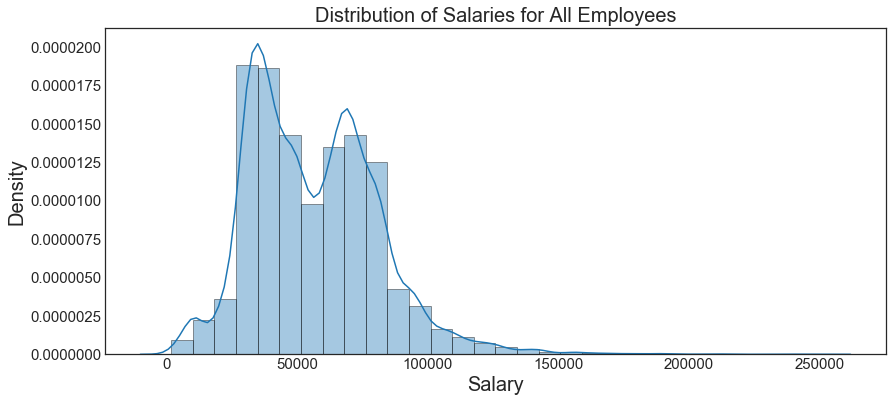

In [17]:
# Summary statistics for salary.
print('\nSummary Statistics for Salary:')
display(pd.DataFrame(salary['Salary'].describe().round(1)).transpose())
print('\n')

# Plot distribution of salaries. 
plt.figure(figsize=(14,6))
b = sns.distplot(salary['Salary'],bins=30,hist_kws=dict(edgecolor="k", linewidth=1))
b.axes.set_title("Distribution of Salaries for All Employees",fontsize=20)
b.set_ylabel("Density",fontsize=20)
b.set_xlabel("Salary",fontsize=20)
b.tick_params(labelsize=15)

#### Note there are two peaks in the distribution of salaries. A zoomed in view will provide a clearer picture of where the peaks in the distribution occur.

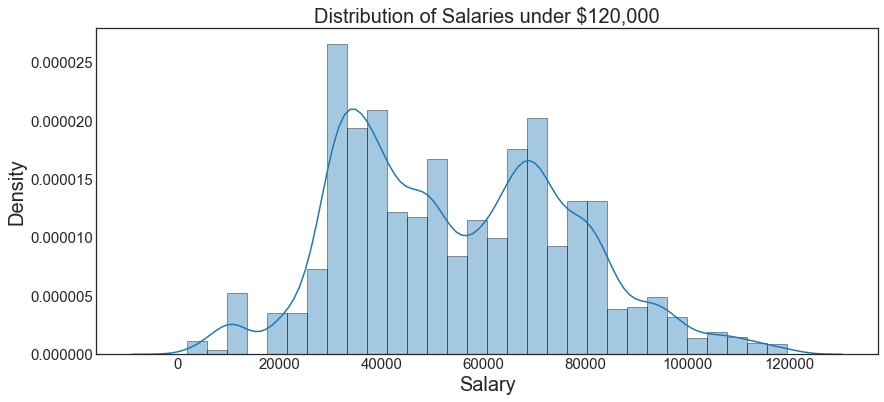

In [18]:
# Plot distribution of salaries under $120,000. 
salary_under_120K = salary[salary['Salary']<120000]
plt.figure(figsize=(14,6))
a = sns.distplot(salary_under_120K['Salary'],bins=30,hist_kws=dict(edgecolor="k", linewidth=1))
a.axes.set_title("Distribution of Salaries under $120,000",fontsize=20)
a.set_ylabel("Density",fontsize=20)
a.set_xlabel("Salary",fontsize=20)
a.tick_params(labelsize=15)

#### The highest density of salaries occurs around \$35,000. As noted above, there appears to be two peaks in the salary distribution. The second peak occurs around \$70,000.

In [19]:
print('\nTop 5 Jobs with Salaries between $60,000 and $80,000:')
df_h = salary[(salary['Salary']>60000) & (salary['Salary']<80000)]['Job Title'].value_counts().head()
df_h = pd.DataFrame(df_h)
df_h.columns = ['Count']
df_h


Top 5 Jobs with Salaries between $60,000 and $80,000:


,Count
police officer,976
emt firefighter suppression,271
police officer eid,182
firefighter/paramedic suppress,135
assistant state's attorney,114


In [20]:
print('\nTop 5 Jobs with Salaries between $25,000 and $45,000:')
df_l = salary[(salary['Salary']>25000) & (salary['Salary']<45000)]['Job Title'].value_counts().head()
df_l = pd.DataFrame(df_l)
df_l.columns = ['Count']
df_l


Top 5 Jobs with Salaries between $25,000 and $45,000:


,Count
laborer,571
office support specialist iii,279
motor vehicle driver i,137
solid waste worker,134
office support specialist ii,121


### 5.(b) Overview of Salary by Department
What does the distribution of salaries look like for employees by department?

In [21]:
def summarize_by_dept(df,col_of_interest,dept_col):
    """
    Args:    Dataframe to summarize, name of column that is of interest (e.g., 'Salary' or 'Years Served'),
             and name of department column to group by
    Returns: Table with summary statistics by department (count, median, and standard deviation)
    """
    cat_group = salary[[col_of_interest,dept_col]].groupby(dept_col)
    cat_med = cat_group.median().round(1)
    cat_cnt = cat_group.count()
    cat_sd = cat_group.std().round(1)
    cat_sum = pd.concat([cat_cnt,cat_med,cat_sd],axis=1)
    cat_sum.columns = ['Count','Median','Standard Deviation']
    cat_sum = cat_sum.sort_values(['Median'],ascending=False).transpose()
    return cat_sum

In [22]:
def perform_ANOVA(col_of_interest):
    """
    Args:    Name of column containing data to test for significant differences amongst 
             departments (hr, comp, etc.; analysis excludes "other" grouping)
    Returns: F statistic and p-value
    """
    groups = salary[[col_of_interest,'Department Code']].groupby('Department Code').groups

    # Extract individual groups
    grp_names = ['hr','comp','oed','fin','m-r','hlth','dpw','trans','r&p','police','fire']
    dct = {}
    for item in grp_names:
        dct['lst_%s' % item] = salary[col_of_interest][groups[item]]

    # Perform the ANOVA
    return stats.f_oneway(dct['lst_hr'],dct['lst_comp'],dct['lst_oed'],
                          dct['lst_fin'],dct['lst_m-r'],dct['lst_hlth'],
                          dct['lst_dpw'],dct['lst_trans'],dct['lst_r&p'],
                          dct['lst_police'],dct['lst_fire']
                         )


Summary Statistics for Salary by Department Category:
(All Salaries Included)


Department Code,police,fire,hr,comp,oed,other,fin,m-r,hlth,dpw,trans,r&p
Count,2981.0,1715.0,76.0,95.0,166.0,2319.0,278.0,418.0,803.0,2344.0,1246.0,444.0
Median,72775.0,69515.0,66450.0,63240.0,54968.5,54026.0,44092.0,41400.0,39983.0,37357.5,35563.5,35429.0
Standard Deviation,18861.2,19571.9,33465.6,27426.7,20753.7,24895.2,28576.1,25641.4,25728.3,16672.2,21329.3,17752.6




P-value from One-Way ANOVA:


0.0

P-value suggests significant differences in salary amongst departments.
(Analysis excludes "other")


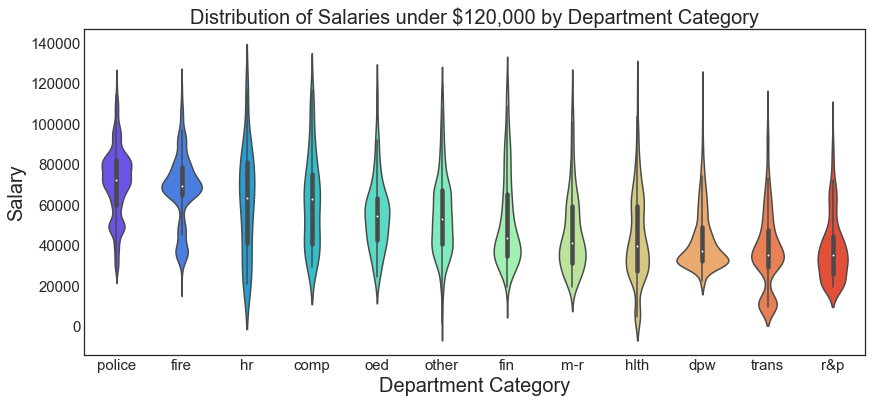

In [23]:
# Summary statistics for salary by department category. 
print('\nSummary Statistics for Salary by Department Category:')
print('(All Salaries Included)')
display(summarize_by_dept(salary,'Salary','Department Code'))
print('\n')

# Perform the ANOVA to test for significant differences in salary amongst departments
# using perform_ANOVA function.
print('P-value from One-Way ANOVA:')
display(perform_ANOVA('Salary')[1].round(6))
print('P-value suggests significant differences in salary amongst departments.')
print('(Analysis excludes "other")')

# Plot distribution of salaries under $120,000 by department category.
# High salaries were excluded to improve visibility of distributions.
plt.figure(figsize=(14,6))
b = sns.violinplot(x='Department Code', y='Salary', data=salary_under_120K, 
                   order=['police','fire','hr','comp','oed','other','fin','m-r','hlth','dpw','trans','r&p'],
                   palette='rainbow')
b.axes.set_title("Distribution of Salaries under $120,000 by Department Category",fontsize=20)
b.set_ylabel("Salary",fontsize=20)
b.set_xlabel("Department Category",fontsize=20)
b.tick_params(labelsize=15)

#### The following observations were made on salaries by department:
- There are significant differences in salaries amongst the departments (note that analysis excluded employees in "other").
- The Police and Fire Departments had the highest median salaries, followed by HR, Comptroller, and Office of Economic Development. 
- Despite having high median salaries, the Police and Fire Departments had relatively small variability in salaries.
- The Transportation department has two peaks in salary groupings with a notable peak around \$10,000. As shown below, this peak around \$10,000 is comprised of Crossing Guards. 

In [24]:
# Check job titles for those in the trans department with salaries under $15,000. 
salary_under_15K = salary[salary['Salary']<15000]
trans_under_15K = salary_under_15K[salary_under_15K['Department Code']=='trans']
print('\nJob Titles and Counts for Transportation Employees')
print('with Salaries under $15,000:')
trans_under_15K_cnt = pd.DataFrame(trans_under_15K['Job Title'].value_counts())
trans_under_15K_cnt.columns = ['Count']
trans_under_15K_cnt


Job Titles and Counts for Transportation Employees
with Salaries under $15,000:


,Count
crossing guard,250
school crossing guard,3


### 5.(c) Overview of Salary by Job Title
Which job titles had the highest salaries? Which had the lowest salaries?

In [25]:
# Summary statistics for salary by job title. 
def summarize_jobs(df):
    """
    Args:    Dataframe to summarize
    Returns: Table with summary statistics by job title; includes median salary, salary standard
             deviation, median years served, and counts.
    """
    job_grp = df.groupby('Job Title')
    med_sal_by_job = job_grp.median()['Salary'].round(1)
    stdev_by_job = job_grp.std()['Salary'].round(1)
    rng_sal_by_job = job_grp.max()['Salary'].round(1) - job_grp.min()['Salary'].round(1)
    med_yrs_by_job = job_grp.median()['Years Served'].round(1)
    count_by_job = job_grp.count()['Department']
    summary_by_job = pd.concat([med_sal_by_job,stdev_by_job,rng_sal_by_job,med_yrs_by_job,count_by_job],axis=1)
    summary_by_job.columns = ['Median Salary','Salary Std Dev','Max - Min Salary','Median Years Served','Count']
    summary_by_job = summary_by_job.sort_values(['Median Salary'],ascending=False)
    return summary_by_job

In [26]:
# Top 10 Job Titles with Highest Salaries
summary_by_job = summarize_jobs(salary).drop(['Salary Std Dev'],axis=1)
job_sort = summary_by_job.round(0)
print('\nTop 10 Job Titles with Highest Salaries: ')
job_sort.head(10)


Top 10 Job Titles with Highest Salaries: 


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
executive director v,250000.0,0.0,0.0,1
state's attorney,238772.0,0.0,12.0,1
police commissioner,212000.0,0.0,3.0,1
city solicitor,188000.0,0.0,0.0,1
director public works,188000.0,0.0,7.0,1
executive director iv,178500.0,0.0,1.0,2
executive director iii,176500.0,65700.0,10.0,11
mayor,175926.0,0.0,1.0,1
city auditor,169600.0,0.0,40.0,1


In [27]:
# Top 10 Job Titles with Lowest Salaries
print('\nTop 10 Job Titles with Lowest Median Salaries: ')
print('(Jobs with 20 or More Employees Shown)')
job_sort_desc = summary_by_job.sort_values(['Median Salary'],ascending=True).round(0)
job_sort_desc[job_sort_desc['Count']>=20].head(10)


Top 10 Job Titles with Lowest Median Salaries: 
(Jobs with 20 or More Employees Shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
sr companion stipend hlth,5512.0,936.0,4.0,52
crossing guard,10864.0,14278.0,12.0,251
serv asst lbry,19240.0,8840.0,3.0,42
community aide,20800.0,11294.0,2.0,147
work study student,21840.0,17368.0,1.0,25
seasonal maint aide,22318.0,8320.0,1.0,114
security guard conv. center,23920.0,0.0,3.0,37
professional asst lbry,25709.0,9651.0,11.0,29
school health aide,26680.0,9771.0,12.0,115


## 6. Overview of Years Served 
#### Years Served are defined as the number of years between employee hire date and December 31st, 2017.

#### Research Questions: <br>a. What does the distribution of years served look like for all employees?<br>b. What does the distribution of years served look like for employees by department?<br>c. Which job titles had the highest median years served? Which had the lowest median years served?

### 6.(a) Overview of Years Served for All Employees
What does distribution of salaries look like for all employees?


Summary Statistics for Years Served:


,count,mean,std,min,25%,50%,75%,max
Years Served,12885.0,13.7,10.5,0.2,4.9,11.5,20.4,55.7


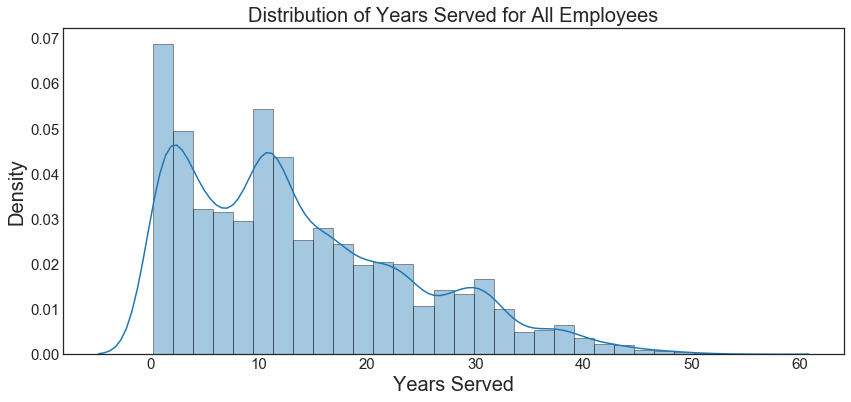

In [28]:
# Summary statistics for years served.
print('\nSummary Statistics for Years Served:')
display(pd.DataFrame(salary['Years Served'].describe().round(1)).transpose())
print('\n')

# Plot distribution of years served. 
plt.figure(figsize=(14,6))
b = sns.distplot(salary['Years Served'],bins=30,hist_kws=dict(edgecolor="k", linewidth=1))
b.axes.set_title("Distribution of Years Served for All Employees",fontsize=20)
b.set_ylabel("Density",fontsize=20)
b.set_xlabel("Years Served",fontsize=20)
b.tick_params(labelsize=15)

#### Years served has a bimodal distribution with peaks at around 0 and 10. <br>The median number of years is 11.5, and approximately 25% of the employees have served over 20 years.

### 6.(b) Overview of Years Served by Department
What does the distribution of years served look like for employees by department?


Summary Statistics for Years Served by Department Category:
(All Salaries Included)


Department Code,oed,fire,police,trans,dpw,comp,other,fin,m-r,r&p,hlth,hr
Count,166.0,1715.0,2981.0,1246.0,2344.0,95.0,2319.0,278.0,418.0,444.0,803.0,76.0
Median,14.0,13.1,12.9,12.5,12.4,10.3,9.8,9.5,9.5,8.6,8.5,3.6
Standard Deviation,11.7,9.7,9.2,11.0,11.4,12.5,11.0,11.7,9.4,10.8,9.3,9.3




P-value from One-Way ANOVA:


0.0

P-value suggests significant differences in years served amongst departments.
(Analysis excludes "other")


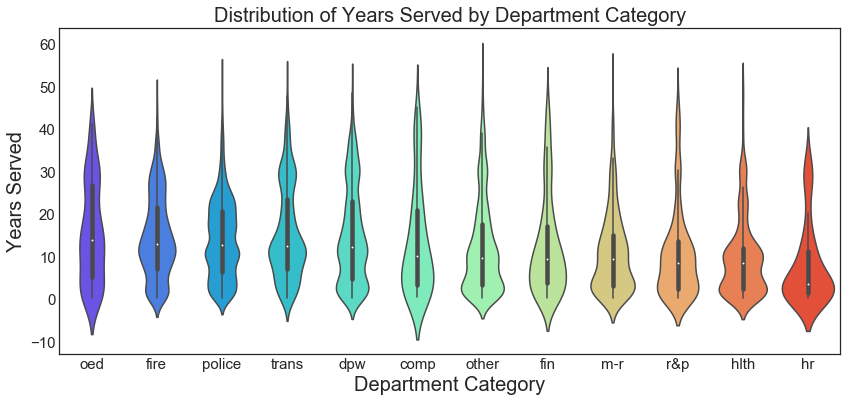

In [29]:
# Summary statistics for years served by department category. 
print('\nSummary Statistics for Years Served by Department Category:')
print('(All Salaries Included)')
display(summarize_by_dept(salary,'Years Served','Department Code'))
print('\n')

# Perform the ANOVA to test for significant differences in years served amongst departments
# using perform_ANOVA function.
print('P-value from One-Way ANOVA:')
display(perform_ANOVA('Years Served')[1].round(6))
print('P-value suggests significant differences in years served amongst departments.')
print('(Analysis excludes "other")')

# Plot distribution of years served by department category.
plt.figure(figsize=(14,6))
b = sns.violinplot(x='Department Code', y='Years Served', data=salary, 
                   order=['oed','fire','police','trans','dpw','comp','other','fin','m-r','r&p','hlth','hr'],
                   palette='rainbow')
b.axes.set_title("Distribution of Years Served by Department Category",fontsize=20)
b.set_ylabel("Years Served",fontsize=20)
b.set_xlabel("Department Category",fontsize=20)
b.tick_params(labelsize=15)

#### The following observations were made on years served by department:
- There are significant differences in years served amongst the departments (note that analysis excluded employees in "other").
- The Office of Economic Development, Fire Department, Police Department, Transportation Department, and Department of Public Works had the highest median years served, whereas HR had the lowest. 

### 6.(c) Overview of Years Served by Job Title
Which job titles had the highest median years served? Which had the lowest median years served?

In [30]:
# Top 10 Job Titles with Highes Median Years Served
print('\nTop 10 Job Titles with Highest Median Years Served: ')
print('(Only jobs with 20 or more employees shown)')
job_sort_desc = summary_by_job.sort_values(['Median Years Served'],ascending=False).round(0)
job_sort_desc[job_sort_desc['Count']>=20].head(10)


Top 10 Job Titles with Highest Median Years Served: 
(Only jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
waste water techn supv i sanit,55164.0,9116.0,30.0,20
battalion fire chief suppress,121220.0,17388.0,30.0,26
mechanical maintenance techiii,49089.0,12900.0,29.0,47
firefighter suppression,78527.0,9012.0,27.0,76
fire captain suppression,105127.0,15080.0,27.0,44
public works inspector iii,67902.0,18743.0,27.0,57
fire lieutenant suppression,87455.0,15970.0,24.0,125
fiscal technician,55666.0,8492.0,23.0,20
police lieutenant,108775.0,14511.0,23.0,51


In [31]:
# Top 10 Job Titles with Lowest Median Years Served
print('\nTop 10 Job Titles with Lowest Median Years Served: ')
print('(Only jobs with 20 or more employees shown)')
job_sort_desc = summary_by_job.sort_values(['Median Years Served'],ascending=True).round(0)
job_sort_desc[job_sort_desc['Count']>=20].head(10)


Top 10 Job Titles with Lowest Median Years Served: 
(Only jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
police officer trainee,48971.0,30718.0,1.0,185
work study student,21840.0,17368.0,1.0,25
law clerk sao,37415.0,14428.0,1.0,31
seasonal maint aide,22318.0,8320.0,1.0,114
emt fire fighter,37320.0,25001.0,1.0,77
maintenance tech apprentice,32114.0,6447.0,1.0,29
grant services specialist ii,37499.0,16688.0,2.0,28
operations techn apprentice,32975.0,9169.0,2.0,38
emergency medical technician,36263.0,3297.0,2.0,96


## 7. Relationship between Salary and Years Served by Job Title
#### Years Served are defined as the number of years between employee hire date and December 31st, 2017.

#### Research Questions: <br>How does salary change based on years served? Do patterns differ by job title within each department?

Sections:<br>
a. Define Functions and Create Dataframes<br>
b. Police Department<br>
c. Fire Department<br>
d. Recreation & Parks<br>
e. Transportation<br>
f. Health Department<br>
g. M-R Department<br>
h. Office of Economic Development<br>
i. Department of Public Works

### 7.(a) Define Functions and Create Dataframes 

In [32]:
def find_freq_jobs(depts,dept_col,cutoff):
    """
    Args:    List of departments, name of department column ('Department' or 'Department Code'),
             and a cutoff for the minimum number of employees within a job title
    Returns: Dataframe that is a subset of salary dataframe containing all departments of interest
             identified in depts list with only those employees whose job titles that meet the
             minimum number of employees criteria
    """
    jobtitles = []
    jobs_lst = []
    df_jobs = []
    
    # Get a nested list of job titles that meet the cutoff criteria for minimum number of 
    # employees within each department of interest.
    for dept in depts:
        dept_cnt = salary[salary[dept_col]==dept]
        dept_cnt = dept_cnt.groupby('Job Title').count()
        dept_cnt = dept_cnt.reset_index()
        dept_subset = dept_cnt[dept_cnt['Department']>=cutoff]
        jobtitles.append(dept_subset['Job Title'])
    
    #Create a list that contains data from the salary dataframe for each job title in the jobtitles list.
    for i in range(len(depts)):
        df_dept = salary[(salary[dept_col]==depts[i])]
        for k in range(len(jobtitles[i])):
            jobs_lst.append(df_dept[df_dept['Job Title']==jobtitles[i].iloc[k]])
        df_jobs.append(pd.concat(jobs_lst))
            
    # Concatenate all items in the list to create one dataframe.
    df_jobs = pd.concat(df_jobs)
    return df_jobs

In [33]:
# Get dataframes for Police Department and Fire Department with job titles that have
# at least 50 employees. This cutoff is based on these departments being quite large.
depts_by_descr = ['police department','fire department']

# Apply find_freq_jobs function to data.
jobs_by_descr = find_freq_jobs(depts_by_descr,'Department',50)

# Separate data by department.
fire_dept = jobs_by_descr[jobs_by_descr['Department']=='fire department']
police_dept = jobs_by_descr[jobs_by_descr['Department']=='police department']

In [34]:
# Get dataframes for departments specified in list below with job titles that have
# at least 20 employees. 
depts_by_code = ['fin','m-r','r&p','trans','hr','comp','hlth','oed']

# Apply subset_by_freq_jobs function to data.
jobs_by_code = find_freq_jobs(depts_by_code,'Department Code',20)

# Separate data by department.
rec_parks = jobs_by_code[jobs_by_code['Department Code']=='r&p']
trans = jobs_by_code[jobs_by_code['Department Code']=='trans']
health = jobs_by_code[jobs_by_code['Department Code']=='hlth']
mr = jobs_by_code[jobs_by_code['Department Code']=='m-r']
oed = jobs_by_code[jobs_by_code['Department Code']=='oed']

In [35]:
# Get dataframe for Department of Public Works with job titles that have
# at least 40 employees. This cutoff is based on this department being quite large.
dpw = ['dpw']
jobs_dpw = find_freq_jobs(dpw,'Department Code',40)
public_wrks = jobs_dpw[jobs_dpw['Department Code']=='dpw']

In [36]:
def summarize_and_plot(dept_df,dept_name,cutoff):
    """
    Args:    Dataframe for a specific department, department name, cutoff used in find_freq_jobs
    Returns: Table with summary statistics by job title and scatterplot showing 
             Salary vs. Years Served with each job title coded in a different color
    """
    # Summary table
    print('\n',dept_name,': Overview of Salary and Years Served by Job')
    print('(Jobs with',cutoff,'or more employees shown)')
    display(summarize_jobs(dept_df).drop(['Salary Std Dev'],axis=1))
    print('\n')
    
    # Plot
    sns.set_context("talk", font_scale=1)
    p = sns.pairplot(x_vars=["Years Served"], y_vars=["Salary"], data=dept_df, 
                 hue="Job Title", size=7, palette='tab20')
    p.fig.suptitle(dept_name, verticalalignment='top', fontsize=20)

In [37]:
def plot_each_job(job_titles,nrow,ncol,fig_width,fig_height,ymin,ymax,xmin,xmax):
    """
    Args:    Job titles to plot and plot layout specifications 
             (number of rows, number of columns, figure width & height, axes specifications)
    Returns: Scatterplots of Salary vs. Years for jobs specified
    """
    # Additional plot specifications.
    myalpha = 0.1
    fig, axes = plt.subplots(nrow, ncol, figsize=(fig_width, fig_height))

    # Initial values for row and column indices.
    irow = 0
    icol = 0

    # Loop through jobs and plot individually.
    for i in range(len(job_titles)):
        # Go to next row when current row is filled.
        if icol == ncol:
            icol = 0
            irow += 1
        # Label y-axis.
        if icol == 0:
            axes[irow,icol].set_ylabel('Salary',fontsize=15)
        # Select data associated with a specific job.
        jobdata = salary[salary['Job Title']==job_titles[i]]
        # Plot salary vs. years.
        axes[irow,icol].scatter(x='Years Served',y='Salary',data=jobdata, alpha = myalpha)
        axes[irow,icol].set_title(job_titles[i],fontsize=15)
        axes[irow,icol].set_xlabel('Years Served',fontsize=15)
        axes[irow,icol].tick_params(labelsize=10)
        if ymin is not None:
            axes[irow,icol].set_ylim([ymin, ymax])
        if xmin is not None:
            axes[irow,icol].set_xlim([xmin, xmax])
        icol += 1

    # Delete unused axes
    extra_ax = (nrow*ncol) % len(job_titles)
    for k in range(extra_ax):
        fig.delaxes(axes[irow][ncol-(1+k)])

    plt.tight_layout()

### 7.(b) Police Department


 Police Department : Overview of Salary and Years Served by Job
(Jobs with 50 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
police lieutenant,108775.0,14511.0,22.7,102
police lieutenant eid,106289.0,16680.0,20.0,112
police sergeant eid,92086.0,19216.0,18.6,182
police sergeant,91569.0,20459.0,19.1,486
police officer eid,74499.0,35091.0,11.2,558
police officer,72094.0,34910.0,12.0,3028
emergency dispatcher,50419.0,15800.0,13.8,140
police officer trainee,48971.0,30718.0,0.8,370


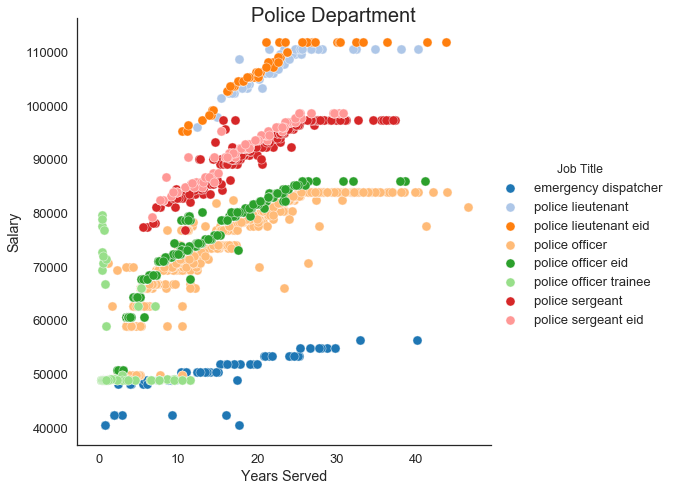

In [38]:
# Summarize and plot data.
summarize_and_plot(police_dept,'Police Department',50)

#### Overview of observations made for Police Department:
- With the exception of Police Officer Trainee and Emergency Dispatcher, trends show that salary plateaus after approximately 25 years of service. See below for estimated plateaus. Note that as stated earlier, the Police Department had one of the highest median years served out of all the departments.
- Salaries for recently hired Police officers compared to those hired over 25 years prior to December 31st, 2017 differed by approximately \$30,000.
- All Police Lieutenants were hired over 12 years prior to December 31st, 2017 (see below).
- There were several recently hired police officer trainees with higher salaries than recently hired police officers.
- Having EID in one's job title does not have a notable impact on salary trends as years served increase. 

In [39]:
# Double check minimum number of years served for Police Lieutenants.
print('Police Lieutenants \nNumber of Years Served for Most Recent Hire:')
police_dept[police_dept['Job Title']=='police lieutenant']['Years Served'].min().round(1)

Police Lieutenants 
Number of Years Served for Most Recent Hire:


12.4

In [40]:
print('\nEstimated Salary Plateaus for Employees in Police Department:')
print('\n(This table summarizes salary information for employees who have served over 25 years.)')
police_over_25yrs = police_dept[police_dept['Years Served']>25]
display(summarize_jobs(police_over_25yrs).drop(['emergency dispatcher']))


Estimated Salary Plateaus for Employees in Police Department:

(This table summarizes salary information for employees who have served over 25 years.)


,Median Salary,Salary Std Dev,Max - Min Salary,Median Years Served,Count
Job Title,,,,,
police lieutenant eid,111880.0,0.0,0.0,30.3,26
police lieutenant,110618.0,328.6,978.0,27.2,32
police sergeant eid,98569.0,391.6,859.0,26.7,22
police sergeant,97309.0,271.8,860.0,27.4,90
police officer eid,85906.0,316.7,716.0,26.9,24
police officer,83881.0,1447.0,13146.0,27.8,246


### 7.(c) Fire Department


 Fire Department : Overview of Salary and Years Served by Job
(Jobs with 50 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
fire lieutenant suppression,87455.0,15970.0,24.3,125
firefighter suppression,78527.0,9012.0,27.3,76
fire pump operator suppression,76165.0,13908.0,20.8,106
fire emergency veh drvr suppr,71097.0,13824.0,16.0,111
paramedic emt-p,70350.0,39083.0,6.9,78
paramedic crt,69802.0,37296.0,12.3,99
firefighter/paramedic suppress,69145.0,31425.0,13.1,141
emt firefighter suppression,65009.0,33743.0,9.4,300
911 operator,45083.0,14428.0,10.8,80


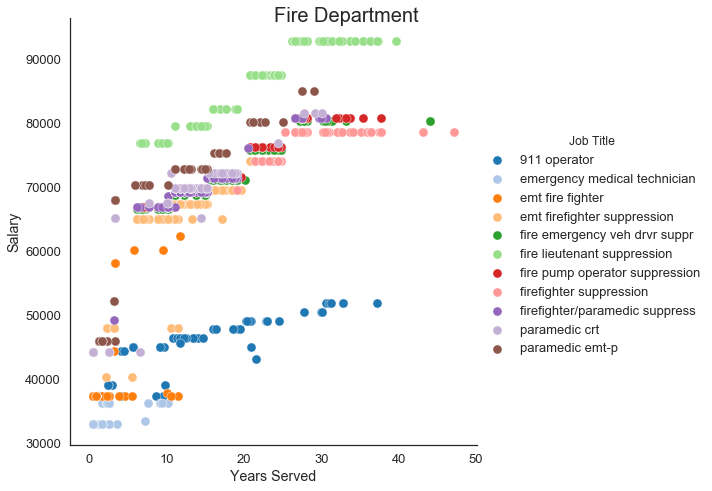

In [41]:
# Summarize and plot the data
summarize_and_plot(fire_dept,'Fire Department',50)

#### To obtain a clearer look, below are plots of each job (axes are standardized).

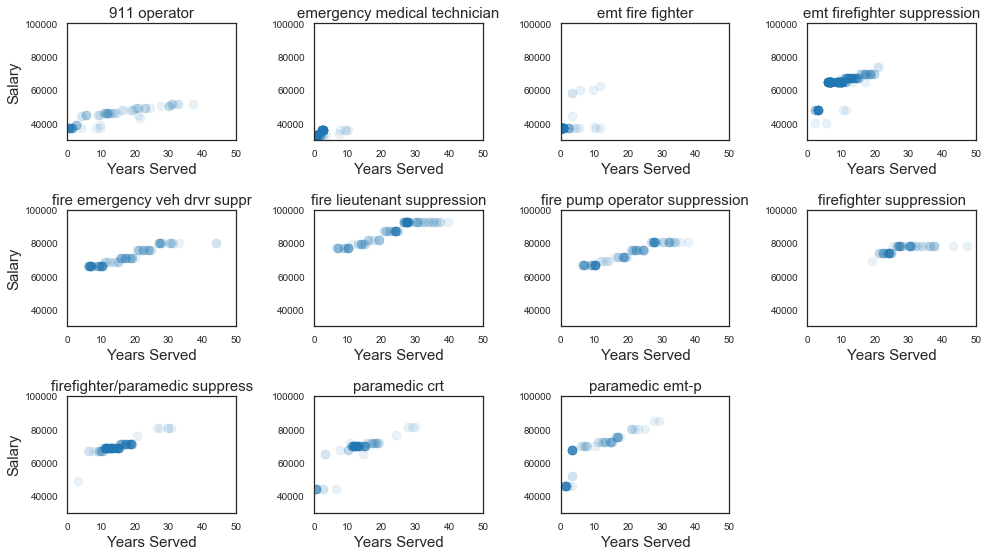

In [42]:
plot_each_job(fire_dept['Job Title'].unique(),3,4,14,8,30000,100000,0,50)

#### Overview of observations made for Fire Department:
- Fire Lieutenant Suppression, Fire Pump Operator Suppression, and Firefighter Suppression positions show that salary plateaus after approximately 25 years of service. See below for estimated plateaus. Note that the other positions do not have as many employees with over 25 years of service. Note that as stated earlier, the Fire Department had one of the highest median years served out of all the departments.
- Fire Lieutenant Suppression had the highest median salary.
- Emergency Medical Technicians and EMT Fire Fighters have mostly recent hires; these positions do not have employees who were hired more than 12 years ago.
- Paramedic CRT, Paramedic EMT-P, and EMT Firefighter Suppression salaries tended to differ greatly for recent hires vs. employees hired a few years prior.
- EMT Firefighter Suppression, Paramedic CRT, Paramedic EMT-P, Firefighter/Paramedic Suppress, and Fire Pump Operator Suppression all had similar salary trends as years served increased. Note that the median years served for Fire Pump Operator Suppression was higher than for the other positions.
- The most recent hire for Firefighter Suppression was hired 19 years prior to December 31st, 2017 (see below).

In [43]:
# Double check minimum number of years served for Firefighter Suppression.
print('Firefighter Suppression \nNumber of Years Served for Most Recent Hire:')
fire_dept[fire_dept['Job Title']=='firefighter suppression']['Years Served'].min().round()

Firefighter Suppression 
Number of Years Served for Most Recent Hire:


19.0

In [44]:
print('\nEstimated Salary Plateaus for Employees in Fire Department:')
print('\n(This table summarizes salary information for employees who have served over 25 years.)')
fire_over_25yrs = fire_dept[fire_dept['Years Served']>25]
jobs = ['fire lieutenant suppression','fire pump operator suppression','firefighter suppression']
display(summarize_jobs(fire_over_25yrs[fire_over_25yrs['Job Title'].isin(jobs)]))


Estimated Salary Plateaus for Employees in Fire Department:

(This table summarizes salary information for employees who have served over 25 years.)


,Median Salary,Salary Std Dev,Max - Min Salary,Median Years Served,Count
Job Title,,,,,
fire lieutenant suppression,92778.0,0.0,0.0,27.8,57
fire pump operator suppression,80801.0,0.0,0.0,28.1,33
firefighter suppression,78527.0,0.0,0.0,30.5,45


### 7.(d) Recreation & Parks


 Recreation & Parks Department : Overview of Salary and Years Served by Job
(Jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
contract serv spec ii,66560.0,55952.0,4.6,186
recreation center director ii,44594.0,8054.0,13.4,120
recreation leader ii,36055.0,11302.0,10.4,264
motor vehicle driver i,33613.0,8100.0,11.5,126
recreation arts instructor,27040.0,20800.0,2.3,348
community aide,20800.0,9880.0,2.5,510


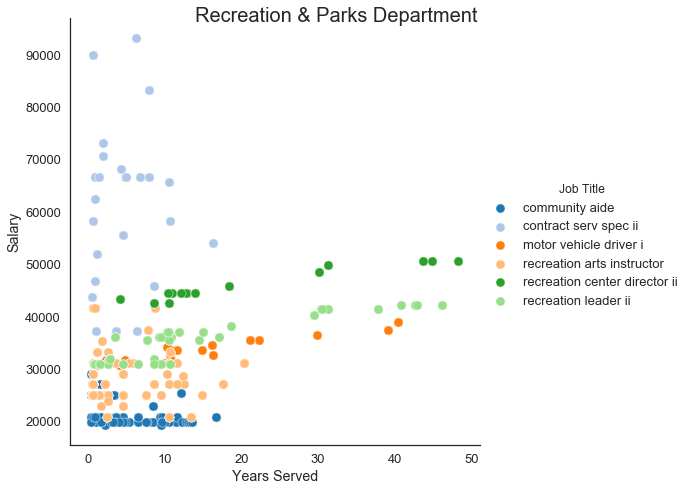

In [45]:
# Summarize and plot the data
summarize_and_plot(rec_parks,'Recreation & Parks Department',20)

#### Overview of observations made for Recreation & Parks:
- Median years served and annual salary for Recreation & Parks for the positions shown tended to be lower than for other departments.
- Contract Services Specialist II had a large spread in salaries.
- Positions with employees hired over 25 years prior to December 31st, 2017 included Motor Vehicle Driver I, Recreation Leader II, and Recreation Center Director II. These positions show a slow incline in salary as years served increase.
- Recreation Arts Instructor shows no relationship between salary and years served (see below).

Pearson r:  -0.1482
p-value:  0.2585


Text(0,0.5,'Salary')

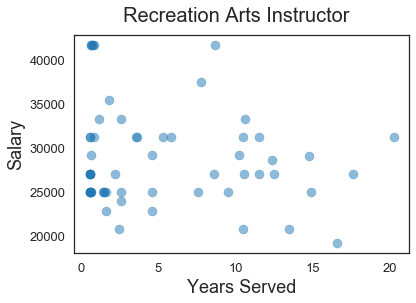

In [46]:
# Select data associated with a specific job.
rec_arts = salary[salary['Job Title']=='recreation arts instructor']

# Compute Pearson Correlation Coefficient
r, p = pearsonr(rec_arts['Years Served'],rec_arts['Salary'])
print('Pearson r: ',r.round(4))
print('p-value: ',p.round(4))

# Plot salary vs. years.
fig = plt.figure()
plt.scatter(x='Years Served',y='Salary',data=rec_arts, alpha = 0.5)
fig.suptitle('Recreation Arts Instructor', fontsize=20)
plt.xlabel('Years Served', fontsize=18)
plt.ylabel('Salary', fontsize=18)

### 7.(e) Transportation Department


 Transportation Department : Overview of Salary and Years Served by Job
(Jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
public works inspector iii,69721.0,18743.0,30.7,145
public works inspector ii,50419.0,16779.0,12.2,160
transportation enforcemt off i,38761.0,11858.0,9.0,390
laborer crew leader ii,37500.0,5305.0,18.5,120
office support specialist iii,35949.0,15576.0,11.7,210
motor vehicle driver i,32635.0,5324.0,10.1,205
traffic maint worker i,32381.0,8748.0,7.4,105
laborer,31345.0,6238.0,11.3,775
office support specialist ii,29138.0,9396.0,3.2,120


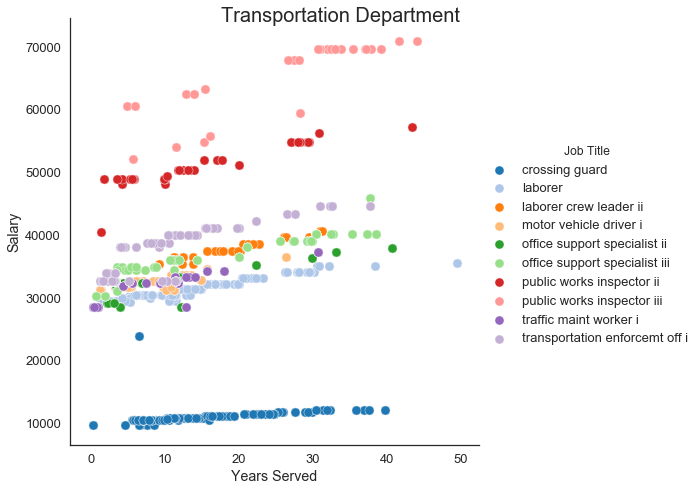

In [47]:
# Summarize and plot the data
summarize_and_plot(trans,'Transportation Department',20)

#### Overview of observations made for Transportation Department:
- All jobs shown had a relatively similar steady increase in salary as years served increased. 
- Salaries within each job title did not differ more than \$19,000, suggesting a tight range of salaries by job title.
- Jobs did not tend to plateau after a certain number of years. Note that as stated earlier, the Transportation Department had one of the highest median years served out of all the departments.
- Public Works inspectors tended to have the highest salaries, and Crossing Guards tended to have the lowest salaries. The remaining job titles had similar salary trends with median salaries in the \$29,000 to \$39,000 range.

### 7.(f) Health Department


 Health Department : Overview of Salary and Years Served by Job
(Jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
community health nurse ii,60138.0,29739.0,9.9,118
contract serv spec ii,40082.0,151320.0,2.5,68
office support specialist iii,36472.5,10570.0,15.7,56
grant services specialist ii,36318.0,16688.0,1.7,48
school health aide,26680.0,9771.0,11.5,230
sr companion stipend hlth,5512.0,936.0,3.5,104


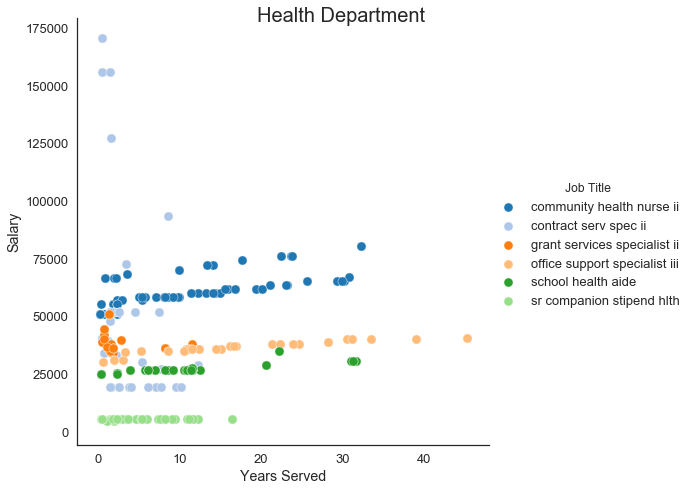

In [48]:
# Summarize and plot the data
summarize_and_plot(health,'Health Department',20)

#### Overview of observations made for Health Department:
- Senior Companion Stipend Health employees, Grant Services Specialist II, and Contract Services Specialist II had the lowest median years served.
- Contract Services Specialist II employees had a wide range of salaries.
- Office Support Specialist III showed a slight but steady increase in salary as years served increased.
- Community Health Nurse II showed an increase in salary as years served increased and also showed a relatively wide range in salaries compared to the other job titles.

### 7.(g) M-R Department


 M-R Department : Overview of Salary and Years Served by Job
(Jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
human services worker i,49557.5,14290.0,17.4,182
public safety officer,41604.0,11398.0,10.1,182
call center agent i,38488.0,8965.0,11.6,329
operations aide,30504.0,4318.0,5.6,231
security guard conv. center,23920.0,0.0,3.2,259


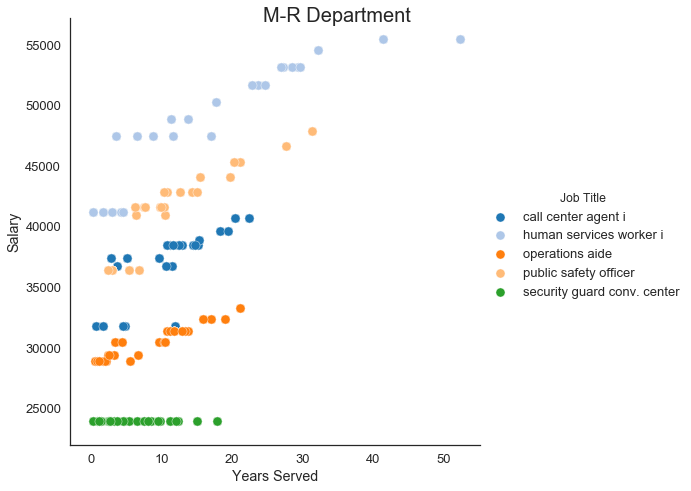

In [49]:
# Summarize and plot the data
summarize_and_plot(mr,'M-R Department',20)

#### Overview of observations made for M-R Department:
- With the exception of Human Services Worker I, the positions shown have a sharp drop off in number of employees who were hired 20+ years prior to December 31st, 2017. Note that as stated earlier, the M-R Department had one of the lowest median years served out of all the departments.
- All Security Guards (Convention Center) had the same salary regardless of years served. All other positions shown had a steady increase in salary as years served increased.

### 7.(h) Office of Economic Development


 Office of Economic Development : Overview of Salary and Years Served by Job
(Jobs with 20 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
professional services,62800.0,19600.0,13.9,30
human services,49498.0,24679.0,14.3,45
facilities/office services i,33451.0,18146.0,11.9,29


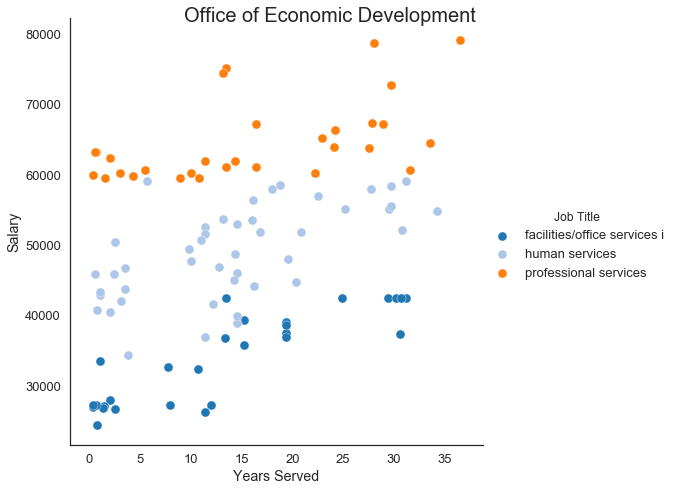

In [50]:
# Summarize and plot the data
summarize_and_plot(oed,'Office of Economic Development',20)

#### Overview of observations made for Office of Economic Development:
- Although the salaries for the positions shown have a positive trend in salary as years served increased, these positions show some of the largest variability in salary after controlling for years served compared to other departments.

### 7.(i) Public Works Department


 Public Works Department : Overview of Salary and Years Served by Job
(Jobs with 40 or more employees shown)


,Median Salary,Max - Min Salary,Median Years Served,Count
Job Title,,,,
engineer i,66100.0,8860.0,2.2,41
mechanical maintenance techiii,49089.0,12900.0,29.2,47
heavy equipment operator ii,43039.0,10565.0,20.1,41
waste water opns tech ii sanit,43039.0,6902.0,18.2,95
motor vehicle driver ii,37669.0,8216.0,16.1,52
office support specialist iii,36996.0,10570.0,15.9,51
solid waste driver,36608.0,8216.0,13.0,64
motor vehicle driver i,33613.0,6947.0,11.3,72
solid waste worker,31512.0,5824.0,10.1,134


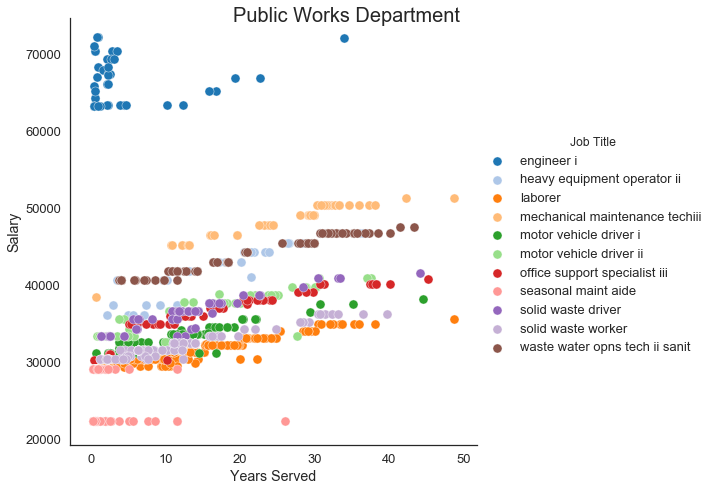

In [51]:
# Summarize and plot the data
summarize_and_plot(public_wrks,'Public Works Department',40)

#### To obtain a clearer look, below are plots of each job (axes are standardized).

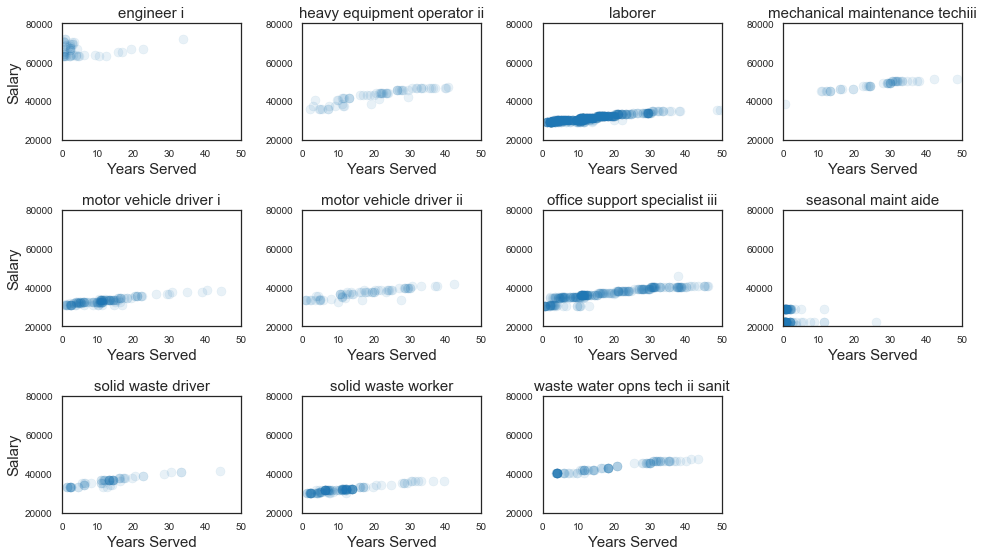

In [52]:
plot_each_job(public_wrks['Job Title'].unique(),3,4,14,8,20000,80000,0,50)

#### Overview of observations made for Public Works Department:
- Seasonal Mainenance Aide and Engineer I were comprised mostly of recent hires. Seasonal Maintenance Aide had the lowest median salary, whereas Engineer I had the highest.
- For the remaining positions, trends in salary as years served increase were fairly similar, although median salaries vary amongst the job titles.
- Jobs did not tend to plateau after a certain number of years. Note that as stated earlier, the Public Works Department had one of the highest median years served out of all the departments. The Public Works Department and Transportation Department are similar in this regard.

## 8. Conclusions

Baltimore City Employee annual salaries from fiscal year 2017 were analyzed for trends in salary based on department, job title, and hire date. Salaries from 12,885 employees were analyzed, which excluded employees labeled as part-time. Note that gross salaries were not included in this analysis.
<br><br>Overview:
- There were large groupings of employees with salaries of approximately \$35,000 (mostly Laborers and Office Support Specialists) and with salaries of approximately \$70,000 (mostly Police Officers and Firefighters).
- Approximately 25% of the employees in the data set had been hired over 20 years prior to the end of 2017.
- The Police and Fire Departments had the highest median salaries, followed by HR, Comptroller, and Office of Economic Development.
- The Office of Economic Development, Fire Department, Police Department, Transportation Department, and Department of Public Works had the oldest median hire date, whereas HR had the most recent median hire date. 
- Most jobs showed strong relationships between salary and hire date with some notable exceptions (Recreation Arts Instructor, Security Guard Convention Center, and Seasonal Mainenance & Community Aides).
<br><br>Police and Fire Departments:<br>
- Despite having relatively high median salaries, the Police and Fire Departments had relatively small variability in salaries.
- Police Officers and Firefighters had some of the steepest increases in salary based on hire date. Salaries tended to differ by approximately \$30,000 between recent hires and those hired 25 years or more ago. After 25 years, salaries within the Police and Fire Departments tended to plateau.
- Jobs comprised of employees with no recent hires include Police Lieutenant and Firefighter Suppression. The most recent hires with these job titles were hired more than 12 years prior to the end of 2017.
<br><br>Transportation Department and Department of Public Works:
- The Transportation Department and Department of Public Works showed consistent but relatively slow increases in salary as the number of years since hired increased. Salaries within these departments did not tend to plateau.
<br><br>Office of Economic Development:
- The Office of Economic Development showed some of the largest variability in salary after controlling for job title and hire date, although there was still an upward trend in salary as years since hired increased.


## 9. Further Research

The Open Baltimore website (https://data.baltimorecity.gov/) features several employee salary data sets spanning multiple years prior to 2017. Analyses looking at salary trends over several years could uncover additional insights on how salaries within certain departments and job titles have changed over time.